## Natural Language Processing - Assignment 2

In Assignment 0, we solved a binary classification problem for tabular data by using a simple Multilayer Perceptron (MLP). The aim was to familiarise yourself with some basic commands to implement a Deep Learning (DL) model and to emphasise the importance of knowing your data. We are now ready to move on to the next level!

Here, we will work with Recurrent Neural Networks (RNN). This family of NN were developed to process sequences of data, where the output depends on previous inputs, making them suitable for tasks like language modeling and time series prediction. However, RNNs suffer from the vanishing gradient problem, which makes it difficult to learn long-term dependencies. To address this, two popular RNN variants that excel at capturing long-term dependencies in sequential data exist: Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRU) networks.

In this assignment, we aim to implement two well-known NLP applications: *sentimental analysis* and *next-word prediction*. In the first problem, we will analyze the content from the text in order to evaluate it as possitive, negative, or neutral content. In the second problem, we aim to predict the nxt word in a sentence. We will split both problems in 3 steps:

* EDA and Data Preprocessing
* Tokenization, Vectorization and Input Pipeline
* Model implementation

Again, the first step is to understand our data. As we are working with text, we will focus on gaining some knowledge about the distribution of both the sequences and the words. Then, we will dive into two well-known process when working with text data: tokenization and vectorization. These concepts refers to the process of splitting text into tokens, and the process of converting those tokens into numerical vectors, respectively. Finally, we will prepare our input pipeline (particularly complex in the second problem), and train our models.

Let's start!

**NOTE**:
- Our model deployment will be carried out with **TensorFlow**. In Kaggle, we can make use of some free GPUs available to speed up the training process. To run notebooks with GPU (we will really need it in this assignment), select the GPU P100 option in the accelerator setting. You will find this option by clicking in the Notebook Settings tab.
- In Keras, there are two ways of defining a model: Sequential (as previous assignment) and Functional API. In this assignment, we are going to use the Keras Functional API. To get familiar with this flexible way to create models, please take a quick look to the Introduction section in [this tutorial](https://www.tensorflow.org/guide/keras/functional#introduction).

**IMPORTANT**:
Througout the different tasks in this assignment, you will find some questions marked as **Q**. These questions must be answered at the end of the Notebook (there is a Markdown cell prepared for this purpose).

## Text Classification

Text classification is the process of assigning predefined categories or labels to text data. It involves analyzing and understanding the content of the text and then categorizing it based on its meaning. Common applications include spam detection, sentiment analysis, and topic classification. In this problem, we will analyze the content from text data in order to evaluate it as possitive, negative, or neutral content.

### EDA and Data Preprocessing

Similar as we did in previous assignment, we will first load and analyze our dataset. In this case, we will use the **Twitter and Reddit Sentimental analysis Dataset**, by Chaithanya Kumar. This dataset consists of tweets and comments posted in Twitter and Reddit regarding Narendra Modi and other indian leaders as well as people's opinion towards the next Prime Minister of India during the general elections held in 2019. If you want to learn more about the information contained in this dataset, check https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import os

import re    # RegEx for removing non-letter characters
import nltk  # Natural language processing
from nltk.corpus import stopwords
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

**Task 1**

Read both datasets. Add an extra column indicating the platform they belong to (Twitter or Reddit). We will use this column for further analyses. First, it is neccesary to manipulate the datasets a bit:
- Search for NaN values that might be present in the data and remove all the missing values.
- Rename the text columns to have the same column name, and adjust the variable type of the category columns to integer.


In [2]:
# Load Twitter dataset
df_tw = pd.read_csv("/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv") # Type your solution here
df_tw['platform'] = 'Twitter'  # Type your solution here

# Output first five rows
df_tw.head(5)

,clean_text,category,platform
0,when modi promised “minimum government maximum...,-1.0,Twitter
1,talk all the nonsense and continue all the dra...,0.0,Twitter
2,what did just say vote for modi welcome bjp t...,1.0,Twitter
3,asking his supporters prefix chowkidar their n...,1.0,Twitter
4,answer who among these the most powerful world...,1.0,Twitter


In [3]:
# Load Reddit dataset
df_re = pd.read_csv("/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv") # Type your solution here
df_re['platform'] = "Reddit" # Type your solution here

# Output first five rows
df_re.head(5)

,clean_comment,category,platform
0,family mormon have never tried explain them t...,1,Reddit
1,buddhism has very much lot compatible with chr...,1,Reddit
2,seriously don say thing first all they won get...,-1,Reddit
3,what you have learned yours and only yours wha...,0,Reddit
4,for your own benefit you may want read living ...,1,Reddit


In [4]:
# Remove NaN values
df_tw = df_tw.dropna() # Type your solution here
df_re =  df_re.dropna()# Type your solution here

# Rename Twitter and Reddit text column names to be 'text'
df_tw.rename(columns={'clean_text': 'text'}, inplace=True)
df_re.rename(columns={'clean_comment': 'text'}, inplace=True)

# Convert Twitter 'category' to integers
df_tw['category'] = df_tw['category'].astype(int)
df_re['category'] = df_re['category'].astype(int)

**Task 2**

For simplicity, we want to combine both dataframes into one. Before that, let's see how similar they are. We will evaluate the length of the comments of each platform. To do so, display the normalized histogram for each platform with respect to the length of the comment in number of characters.

**Hint**. Create an extra column on each dataframe containing the number of character. This can be done with *.apply(len)*. And the normalized histogram can be plot with Seaborn (*sns.histplot(..., stat='density')*).

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


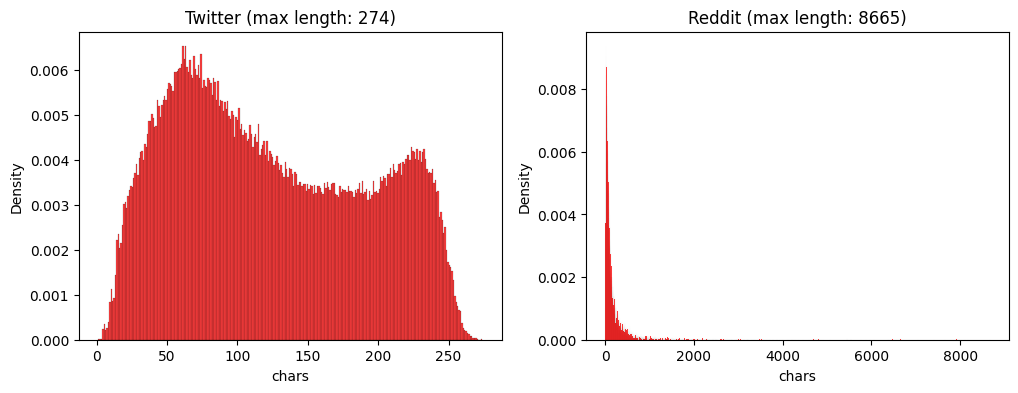

In [5]:
# Count the number of characters in the text
df_tw['chars'] = df_tw['text'].apply(len)
df_re['chars'] = df_re['text'].apply(len)

# Plot histograms
fig = plt.figure(figsize=(12,4))

for i, j in enumerate(zip([df_tw, df_re], ['Twitter', 'Reddit'])):
    _df, title = j
    plt.subplot(1,2,i+1)
    sns.histplot(_df['chars'], bins=_df['chars'].max(), color='red', stat="density")
    plt.title(title + " (max length: %d)" % _df['chars'].max())

plt.show()

Notice that Twitter had a limitation of 280 characters when typing a comment. However, there is no such restriction in Reddit, so the histogram is more similar to a right-skewed distribution. Since we want to combine both datasets, we can malipulate the Reddit data so that we filter out the comments that does not meet the Twitter character criterion. Hence, both datasets have a similar comment length.

Reddit samples before filtering: 37149
Reddit samples after filtering: 31253


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


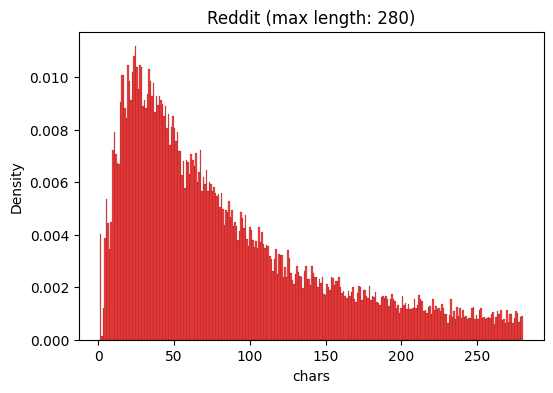

In [6]:
# Filter out Reddit comments
print("Reddit samples before filtering: %d" % len(df_re))
df_re = df_re[df_re['chars'] <= 280] # Type your solution here
print("Reddit samples after filtering: %d" % len(df_re))

# Check new histogram
fig = plt.figure(figsize=(6,4))
sns.histplot(df_re['chars'], bins=df_re['chars'].max(), color='red', stat="density")
plt.title("Reddit" + " (max length: %d)" % df_re['chars'].max())
plt.show()

**Task 3**

As expected, we have not loss too many samples from the Reddit dataset.

Let's continue with the data cleaning. Create a function that converts the text to lowercase and remove any non-letter or non-number chars. We will apply this function to both datasets.

In [7]:
def clean_text(string):

    # Convert to lowercase
    text = string.lower()

    # Remove non letter or digit characters. Use the regular expression pattern r"[^a-zA-Z0-9]".
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    return text

In [8]:
# Previous text
print('Original text: ', df_tw['text'][0])

# Apply clean_text
df_tw['clean_text'] = df_tw['text'].apply(clean_text) # Type your solution here
df_re['clean_text'] = df_re['text'].apply(clean_text) # Type your solution here

# Clean text
print('Clean text: ', df_tw['clean_text'][0])

Original text:  when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
Clean text:  when modi promised  minimum government maximum governance  expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples


/tmp/ipykernel_36/4080597868.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_re['clean_text'] = df_re['text'].apply(clean_text) # Type your solution here


**Task 4**

Great! Now that our datasets seems to be clean, we can combine them and do more data visualizations. Let's start by showing what the distribution of each platform is and the number of occurrences each dataset is providing. Show barplors of the platform distribution and the category count per platform using *plt.bar()*.

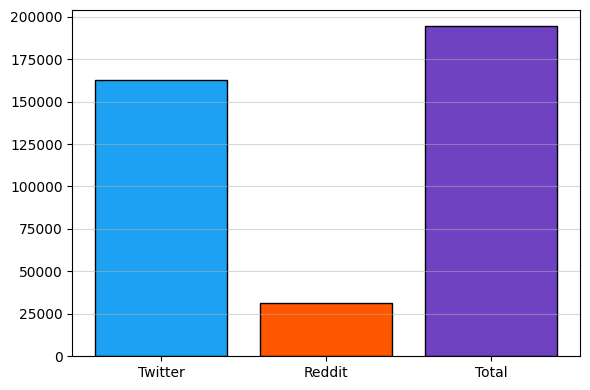

In [9]:
# Concatenate datasets. Set ignore_index to True
df = pd.concat([df_tw, df_re], ignore_index=True) # Type your solution here

# Platform distribution
counts = [len(df_tw), len(df_re), len(df)]
labels = ['Twitter', 'Reddit', 'Total']
colors = ['#1DA1F2', '#FF5700', '#6F42C1']

# Plot
plt.figure(figsize=(6,4))

plt.bar(labels, counts, color=colors, edgecolor='black') # Type your solution here
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

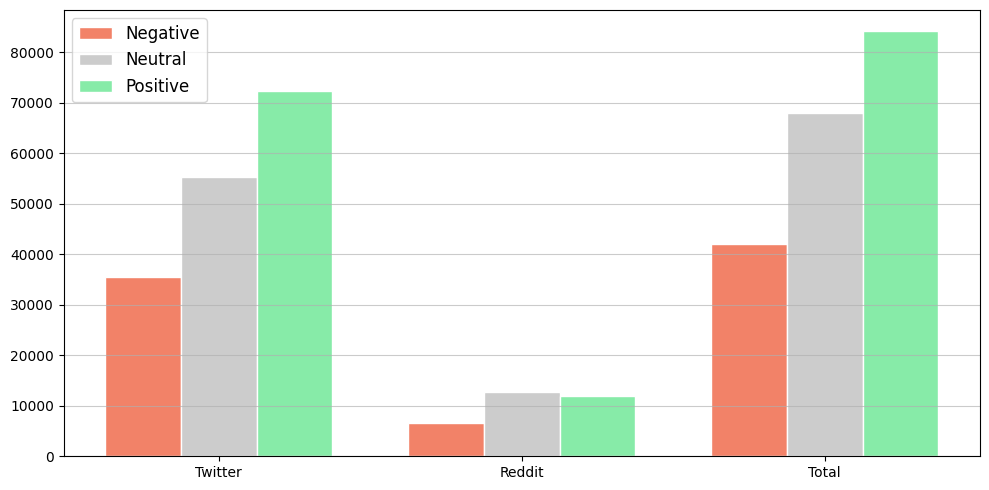

In [10]:
# Count number of ocurrences of each category and each platform (Twitter, Reddit, Both)
negative_count = [len(df_tw[df_tw['category'] == -1]), # Type your solution here
                  len(df_re[df_re['category'] == -1]),
                  len(df[df['category'] == -1])]

neutral_count = [len(df_tw[df_tw['category'] == 0]), # Type your solution here
                 len(df_re[df_re['category'] == 0]),
                 len(df[df['category'] == 0])]

positive_count = [len(df_tw[df_tw['category'] == 1]), # Type your solution here
                  len(df_re[df_re['category'] == 1]),
                  len(df[df['category'] == 1])]

# X-indexes for plotting
x = ['Twitter', 'Reddit', 'Total']
x_indexes = np.arange(len(x))
width = 0.25

# Plot
plt.figure(figsize=(10,5))

plt.bar(x_indexes - width, negative_count, width=width, label='Negative', edgecolor='white', color='#f28268')
plt.bar(x_indexes, neutral_count, width=width, label='Neutral', edgecolor='white', color='#cccccc')
plt.bar(x_indexes + width, positive_count, width=width, label='Positive', edgecolor='white', color='#87EBA8')

plt.yticks(fontsize=10)
plt.xticks(ticks=x_indexes, labels=x, fontsize=10)

plt.legend(prop={'size':12})
plt.grid(axis='y', alpha=0.65)
plt.tight_layout()

As you can see from the previous plots, most of the comments belong to the Twitter platform (around 80% of the data), while the Reddit platform is less represented (20% of the data). In any case, the combination of both dataset allow us to work with approximately 200k samples! We also see some imbalance in the categories, but hopefully it will not affect too much to our results.

### Tokenization, Vectorization and Input Pipeline

**Task 5**

An important step during NLP applications is the tokenzation. It consist of breaking down text into smaller units called tokens, for instance, words. Split the text in words and count the number of words per comment. Then, we will do a couple of visualizations more to get a better understanding of our data before moving on.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


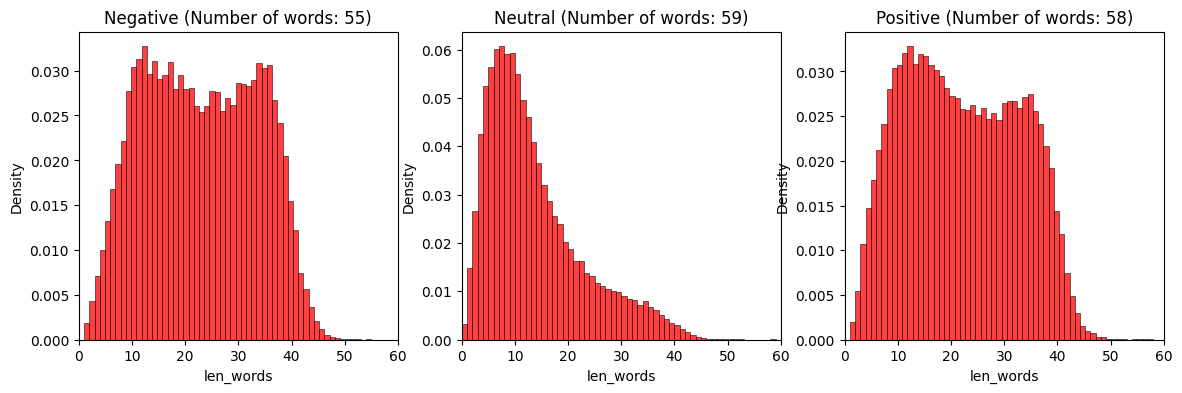

In [11]:
fig = plt.figure(figsize=(14,4))

# Split text by words and count them
df['words'] = df['clean_text'].apply(lambda x: x.split()) # Type your solution here. Use a lambda function together with split()
df['len_words'] = df['words'].apply(len) # Type your solution here

for i, j in enumerate(zip([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])):
    category, title = j
    plt.subplot(1,3,i+1)
    _df = df[df['category']==category]
    plt.xlim((0,60))
    sns.histplot(_df['len_words'], bins=_df['len_words'].max(), color='red', stat="density")
    plt.title(title + " (Number of words: %d)" % _df['len_words'].max())

plt.show()

We see that the distribution of the number of words is quite similar between Positive and Negative caegories. On the other hand, Neutral comments seem to be shorter, with a lower number of words.

We can also visualize the most common words for each category in a fancy wordcloud plot.

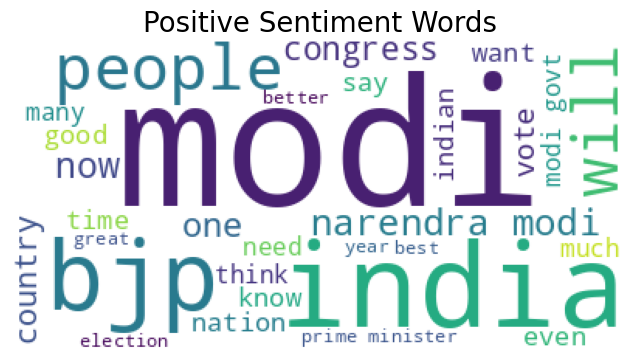

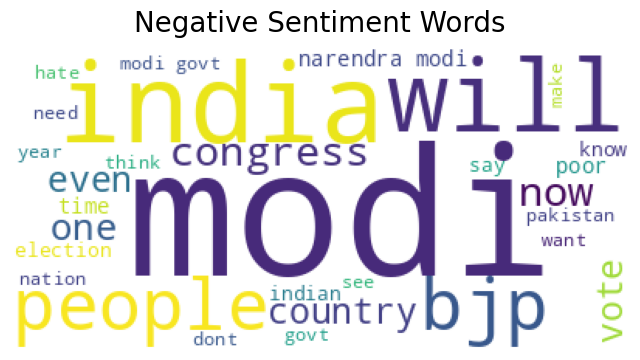

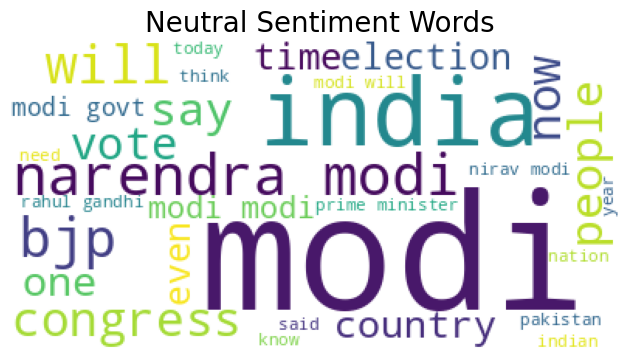

In [12]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category, title):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''

    # Initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=30,
                   stopwords = STOPWORDS)

    # Find tweets for a specific category
    comments = " ".join([comment for comment in df[df.category==category]['text']])

    # Generate and plot wordcloud
    plt.figure(figsize=(8,8))
    plt.imshow(wc.generate(comments))
    plt.title('{} Sentiment Words'.format(title), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(df, 1, 'Positive') # Type your solution here

# Negative tweet words
wordcount_gen(df, -1, 'Negative') # Type your solution here

# Neutral tweet words
wordcount_gen(df, 0, 'Neutral') # Type your solution here

**Task 6**

Time to prepare the data for the architecture! Remember that we already have the dataframe containing the content in token form and category of each text. We will split in training, validation and test. Make use of the dataframe to obtain a train set with 80% of the data. The remaining data will be equally divided into validation and test set. Use train_test_split() funtion including *suffle=True* , *random_state=0* and *stratify* arguments when splitting. More info here https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

**Note**. For simplicity druing training, we will shift the labels.

In [13]:
# Shift labels from [-1, 0, 1] to [0, 1, 2]
df['encoded_category'] = df['category'].apply(lambda x: x + 1) # Type your solution here. Use a lambda function

# Split dataset
train_df, Temp_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=0, stratify=df['encoded_category'])  # Type your solution here
valid_df, test_df = train_test_split(Temp_df, test_size=0.5, shuffle=True, random_state=0, stratify=Temp_df['encoded_category']) # Type your solution here

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Shape of the training set:", train_df.shape)
print("Shape of the validation set:", valid_df.shape)
print("Shape of the testing set:", test_df.shape)

Shape of the training set: (155377, 8)
Shape of the validation set: (19422, 8)
Shape of the testing set: (19423, 8)


**Task 7**

After tokenization, each token is mapped to a vector (often a sequence of numbers) in a vector space. This process is called vectorization. This step of converting text into numerical representations can be implemented with *tf.keras.layers.TextVectorization*. The numerical representation is based on the frequency of individual string values, including an "Out-Of-Vocab" (OOV) token. Let's first take a detailed look at the word distribution in our dataset.

- Remove those comments that, after data cleaning, does not contain any word (len_words < 1).
- Count all the words (non-repeated) that are used in the comments.

**Note**: Actually, TextVectorization implements both Tokenization and Vectorization. For simplicity, we will only employ this layer on the following steps.

In [14]:
# Keep comments with more than one word
df = df[df['len_words'] >= 1] # Type your solution here

# Find non-repeated words
list_words = []
for words in df['words']:
    list_words += words # Type your solution here

num_unique_words = len(set(list_words)) # Type your solution here

print(f"Number of words: {num_unique_words} words")
print(pd.Series(list_words).value_counts())

Number of words: 118335 words
modi             158131
the              123582
and               76608
for               57940
you               44059
                  ...  
redditgau             1
telltales             1
bhya                  1
matriculation         1
porotta               1
Name: count, Length: 118335, dtype: int64


See that the word distribution is far from being uniform. We also notice a large number of non-repeated words. Take into account the source of the data (Twitter and Reddit, aka the Internet), meaning that misspelled words, slang vocabulary, and mistranslations are expected to exist. It is a common practice to use a fixed vocabulary size, like 10000. This imply that the vectorization will be implemented considering the 9999 most frequent words (remember the OOV token).

Set the limit of the vocabulary size and define the TextVectorization layer.

In [15]:
from tensorflow.keras.layers import TextVectorization

# Maximum size of the vocabulary
max_tokens = 10000 # Type your solution here

# Define the TextVectorization layer. Set output_mode='int'
vectorize_layer = TextVectorization( # Type your solution here
    max_tokens=max_tokens,
    output_mode='int',
)

# Adapt the vectorization layer to the text data. Use the method .adapt()
vectorize_layer.adapt(df['clean_text']) # Type your solution here

**Task 8**

Buidling the input pipeline for this task is simple. Similar to what we did in Assignment 1, we will implement two different fucntions:

**Text_classification_preprocessing**: It contains the preprocessing steps.

- Vectorize the text by calling vectorize_layer.
- Add zero-padding at the beginning of the tokenized sentence up to the length of the longest sequence.

**Text_classification_dataset**: It builds the pipeline.

- Create a dataset with a separate element for each row of the input with Dataset.from_tensor_slices.
- Apply the preprocessing function across the elements of the dataset with the map() method.
- Combines consecutive elements of this dataset into batches with the batch() method.

**Hint**: In this case, we need to add the *padding* argument to the preprocessing function. For adding extra arguments when building the pipeline, we can use a *lambda* function to "extract" the elements from the dataset. Then, you call the preprocessing function defining all the input arguments.

```
dataset.map(lambda x, y: map_func(x, y, args))
```

**Q1**: Talking about the padding, why do we actually need to pad the text to the size of the longest sequence? Is there any difference between padding before or after each sequence?

In [16]:
from tensorflow.data import Dataset
import tensorflow as tf

def text_classification_preprocessing(text, category, padding):

    # Vectorize the text
    text = vectorize_layer(text) # Type your solution here

    # Add zero-padding before the sequence with tf.pad()
    text = tf.pad(text, [[padding - tf.shape(text)[0], 0]]) # Type your solution here

    return text, category


def text_classification_dataset(data, batch_size, padding):

    # Create dataset object. Use (data['clean_text'], data['encoded_category']) as input data.
    dataset = Dataset.from_tensor_slices((data['clean_text'], data['encoded_category'])) # Type your solution here

    # Map the text_classification_preprocessing function
    dataset = dataset.map(lambda x, y: text_classification_preprocessing(x, y, padding), num_parallel_calls=tf.data.AUTOTUNE) # Type your solution here

    # Add batch information
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) # Type your solution here

    return dataset

### Model Implementation

**Task 9**

Create a RNN model to implement the text classification text. Employ an Embedding layer with 128 as dimension of the dense embedding. Add a LSTM layer with 128 units, and a classifier layer with the corresponding number of units and activation function.

**Q2**: Briefly explain the purpose of the Embedding layer.

**Q3**: What kind of activation functions are used in a LSTM cell?

In [17]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

# For speeding up training but with lower precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Define the LSTM model
def text_classification_lstm():
    inputs = Input(shape=(output_sequence_length,)) # Type your solution here

    x = Embedding(max_tokens, 128)(inputs) # Type your solution here
    x = LSTM(128)(x) # Type your solution here
    output = Dense(3, activation='softmax')(x) # Type your solution here

    model = Model(inputs, output)

    model.summary()

    return model

**Task 10**

Time to train the model. Create the training and validation datasets with the proper padding. Then, compile the model using the Adam optimizer with a learning rate of 0.0001, the right loss function, and "accuracy" as metric. Train the model for 10 epochs and display the train/val curves.

In [18]:
from tensorflow.keras import optimizers
# Desired length of each sequence (padded/truncated). Use the length of the longest sequence in your data
output_sequence_length = int(df['len_words'].max()) # Type your solution here

cla_train_dataset = text_classification_dataset(train_df, 64, output_sequence_length) # Type your solution here
cla_valid_dataset = text_classification_dataset(valid_df, 64, output_sequence_length) # Type your solution here

cla_model = text_classification_lstm() # Type your solution here

cla_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Type your solution here

# Train the model
history = cla_model.fit(
    x=cla_train_dataset, # Type your solution here
    validation_data=cla_valid_dataset, # Type your solution here
    epochs=10)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 59)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 59, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,971 (5.39 MB)

 Trainable params: 1,411,971 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.6281 - loss: 0.8152 - val_accuracy: 0.9096 - val_loss: 0.2713
Epoch 2/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9305 - loss: 0.2289 - val_accuracy: 0.9455 - val_loss: 0.1812
Epoch 3/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9562 - loss: 0.1563 - val_accuracy: 0.9516 - val_loss: 0.1630
Epoch 4/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9639 - loss: 0.1349 - val_accuracy: 0.9527 - val_loss: 0.1630
Epoch 5/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9673 - loss: 0.1225 - val_accuracy: 0.9548 - val_loss: 0.1583
Epoch 6/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9710 - loss: 0.1116 - val_accuracy: 0.9530 - val_loss: 0.1618
Epoch 7/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9738 - loss: 0.1015 - val_accuracy: 0.9565 - val_loss: 0.1547
Epoch 8/10
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9760 - loss:

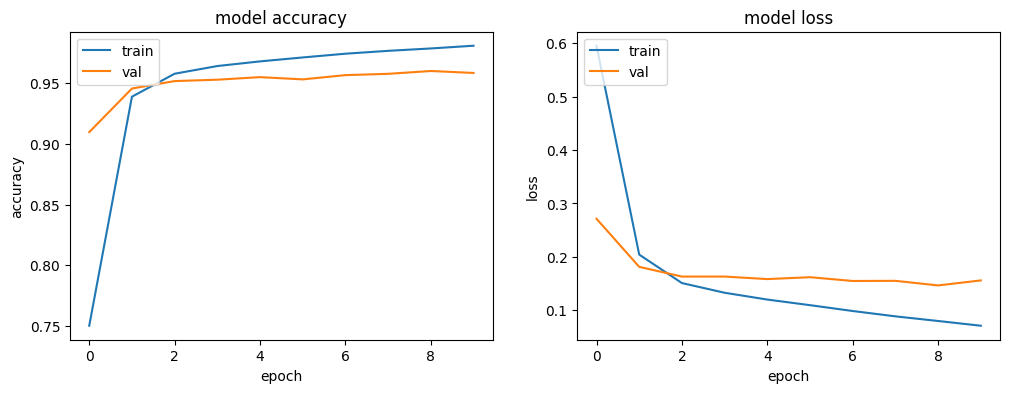

In [19]:
# Plot the accuracy curves
f,ax=plt.subplots(1,2,figsize=(12,4))

ax[0].plot(history.history['accuracy']) # Plot training accuracy
ax[0].plot(history.history['val_accuracy']) # Plot validation accuracy
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss']) # Plot training loss
ax[1].plot(history.history['val_loss']) # Plot validation loss
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

**Task 11**

As we did in Assignment 1, let's evaluate the performance of the model on the test set by displaying the confusion matrix.

In [20]:
import itertools

def plot_confusion_matrix(cm: np.array,
                          classes: list,
                          title: str = 'Confusion matrix',
                          cmap: object = plt.cm.YlGn):
    """
    This function prints and plots the confusion matrix (cm). Normalization
    can be applied by setting 'normalize=True'.

    Parameters:
    ----------
    cm : np.array
        Confusion matrix.
    classes : list
        Data labels.
    normalize : bool, optional
        Apply or not normalization. The default is False.
    title : str, optional
        Title of the image. The default is 'Confusion matrix'.
    cmap : object, optional
        Color map. The default is 'plt.cm.YlGn'.

    Returns
    -------
    None

    """

    plt.figure(figsize=(8, 8), dpi=144, facecolor='w', edgecolor='k')

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm_norm.max() / 2.

    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=7)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=7, wrap=True)
    plt.yticks(tick_marks, classes, fontsize=7, wrap=True)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        cm = cm.astype('int')
        plt.text(j, i, (("%.2f (%d)" % (cm_norm[i, j], cm[i, j]))),
                     horizontalalignment="center", fontsize=7,
                     color="white" if cm_norm[i, j] > thresh else "black")

    plt.ylabel('True Label', fontsize=7)
    plt.xlabel('Predicted Label', fontsize=7)
    plt.tight_layout()

304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy test: 0.955310714101838


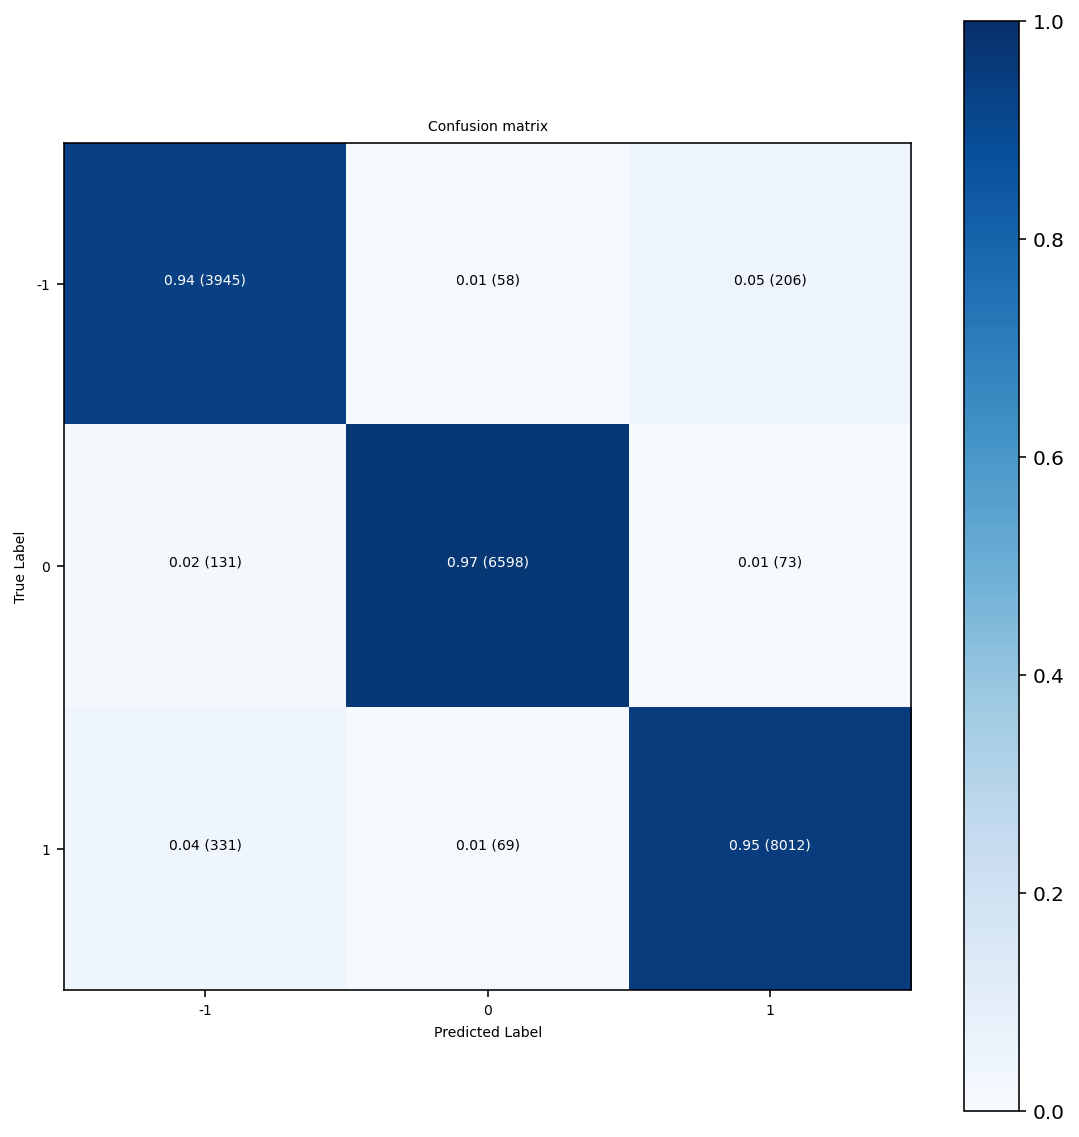

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Define test generator
cla_test_dataset = text_classification_dataset(test_df, 64, output_sequence_length) # Pass test_df, batch_size and output_sequence_length

# Use the test set
predictions = cla_model.predict(cla_test_dataset) # Predict on the test dataset

# Threshold the predictions and apply argmax to get the class (axis=1)
class_pred = np.argmax(predictions, axis=1) # Apply argmax on predictions with axis=1

# Convert class_pred to original categories
class_pred_list = class_pred - 1

# Create confusion matrix
conf_mat = confusion_matrix(test_df['category'], class_pred_list) # Pass true labels and predicted labels

# Obtain accuracy with argmax
acc_test = accuracy_score(test_df['category'], class_pred_list) # Pass true labels and predicted labels

print("Accuracy test:", acc_test)

plot_confusion_matrix(cm=conf_mat, classes=df['category'].unique(),
                      title='Confusion matrix', cmap='Blues')

It seems that our model performs quite well! For fun, let's run inference in our own sentences. You do not need to complete any code here, just run the cell :)

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_class(text, padding=59):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']

    # Transforms text to a sequence of integers using a tokenizer object
    xt = vectorize_layer(text)

    # Pad sequences to the same length
    xt = tf.pad(xt, [[padding - tf.shape(xt)[0], 0]])

    # Add batch dimension
    xt = tf.expand_dims(xt, axis=0)

    # Do the prediction using the loaded model
    yt = cla_model.predict(xt).argmax(axis=1)

    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [23]:
predict_class('I think Modi is a good choice')

predict_class('I like pizza')

predict_class('This is the worst for indian people')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
The predicted sentiment is Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The predicted sentiment is Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The predicted sentiment is Negative


## Next-Word Prediction

Next-word prediction is a task in NLP where a model is trained to predict the next word in a sentence based on the words that precede it. This involves using sequences of words as input and learning patterns in the data to accurately predict the next word.

### EDA and Data Preprocessing

We will use the **Text Generator dataset, Next Word Predictor, LLMs** dataset, by Ashish Pandey. This is a large text file which contains the plain text of various fields and topics. If you want to learn more about the information contained in this dataset, check https://www.kaggle.com/datasets/ashishpandey2062/next-word-predictor-text-generator-dataset/data.

**Task 12**

Since we have already covered some of the basic steps of EDA and data cleaning in the previous problem, we will move straigh fowards in this section. Read the file as a whole raw text. Then, display an example of the first 500 characters.

In [24]:
# Open the text file in read mode with UTF-8 encoding
with open('/kaggle/input/next-word-predictor-text-generator-dataset/next_word_predictor.txt', 'r', encoding='utf-8') as file: # Type your solution
    # Read the contents of the file and assign it to the variable 'data'
    full_text = file.read()

print(full_text[:500]) # Type your solution

The sun was shining brightly in the clear blue sky, and a gentle breeze rustled the leaves of the tall trees. People were out enjoying the beautiful weather, some sitting in the park, others taking a leisurely stroll along the riverbank. Children were playing games, and laughter filled the air.

As the day turned into evening, the temperature started to drop, and the sky transformed into a canvas of vibrant colors. Families gathered for picnics, and the smell of barbecues wafted through the air.


As you see, the raw text contains both sentences and paragraphs. For this next word prediction task, we can decide what kind of text data extract. For simplicity, let's find all the sentences by splitting the text by the full stop punctuations ("."). Store all the sentences in a DataFrame

In [25]:
full_text_seq = full_text.split('.') # Type your solution

gen_df = pd.DataFrame()
gen_df['text'] = full_text_seq # Type your solution

gen_df.head()

,text
0,The sun was shining brightly in the clear blue...
1,People were out enjoying the beautiful weathe...
2,"Children were playing games, and laughter fil..."
3,"\n\nAs the day turned into evening, the temper..."
4,"Families gathered for picnics, and the smell ..."


Finally, as we previously did, map the *clean_text* function to each sentence and count the number of words. We will include an extra line to remove the **newline** "\n" character.

In [26]:
# Clean text
gen_df['clean_text'] = gen_df['text'].apply(clean_text)

# Remove newline \n
gen_df['clean_text'] = gen_df['clean_text'].apply(lambda x: x.replace('\n', ' '))

# Split words
gen_df['words'] = gen_df['clean_text'].apply(lambda x: x.split())

# Count words
gen_df['len_words'] = gen_df['words'].apply(len)

### Tokenization, Vectorization and Input Pipeline

**Task 13**

Let's do some evaluation of the number of words. First, we will remove those sentences that contains one word or less as they are not useful for this task. Then, count the number of non-repeated words.

In [27]:
# Filter out sentences with one word or less
gen_df = gen_df[gen_df['len_words'] > 1]

# Find non-repeated words
list_words = []
for words in gen_df['words']:
    list_words += words

num_unique_words = len(set(list_words))

print(f"Number of words: {num_unique_words} words")
print(pd.Series(list_words).value_counts())

Number of words: 4824 words
the          1418
and           859
a             718
of            689
to            597
             ... 
europe          1
pierce          1
hilltops        1
silent          1
guardians       1
Name: count, Length: 4824, dtype: int64


In this case, the number of words is quite lower compare to the previous problem. Despite there are a few words that only appear once in the text, we will aim to use the whole vocabulary for defining the TextVectorization layer.

In [28]:
# Define the TextVectorization layer. Set output_mode='int'
vectorize_layer = TextVectorization(
    max_tokens=num_unique_words,
    output_mode='int',
)

# Adapt the vectorization layer to the text data. Use the method .adapt()
vectorize_layer.adapt(gen_df['clean_text'])

**Task 14**

Building the input pipeline is going to be a bit more complex as previous pipelines. We will implement a procedure called **incremental sequences**. This method generates multiple sequences where each sequence is built by progressively adding more elements from a larger sequence. If the original sentence is "The cat sat on the mat", incremental sequences could be:

"The" - *cat*

"The cat" - *sat*

"The cat sat" - *on*

"The cat sat on" - *the*

"The cat sat on the" - *mat*

Each incremental sequence (marked as "") can be used to train a model to predict the next word (indicated in *italics*) based on the progressively larger context. In any case, we will follow the same 2-function structure:

**Text_generation_preprocessing**: It contains the preprocessing steps.

- Vectorize the text by calling vectorize_layer.
- Apply incremental sequences and add zero-padding at the beginning of the tokenized sentence up to the length of the longest sequence.

**Text_generation_dataset**: It builds the pipeline.

- Create a dataset with a separate element for each row of the input with Dataset.from_tensor_slices. In this case, we only have input data, but not category.
- Apply the preprocessing function across the elements of the dataset with the map() method.
- Flat the incremental sequences.
- Combines consecutive elements of this dataset into batches with the batch() method.

**Hint**: Incremental sequences generate a total of *length-1* samples (following the same naming that the following cell) with padding. This mean that, for every sentence, we will generate sequences of shape $(length-1, padding)$. With *flat_map()* together with *Dataset.from_tensor_slices*, we are telling TensorFlow to take each incremental sequence and use it as a single element.

In [29]:
from tensorflow.data import Dataset
import tensorflow as tf

# Convert the text data into sequences where the model will learn to predict the next word in a sequence
def text_generation_preprocessing(text, padding):

    # Vectorize the text and convert tensor to int32
    tokenized_text = vectorize_layer(text)
    tokenized_text = tf.cast(tokenized_text, dtype=tf.int32)

    # Get the length of the tokenized sequence
    length = tf.shape(tokenized_text)[0]

    def slice_fn(i):
        # Incremental sequence of i-1 words
        input_sequence = tf.pad(tokenized_text[:i-1], [[padding - i + 1, 0]])

        # Last word is reserved as the category
        output_word = tokenized_text[i]

        return input_sequence, output_word

    # Evaluate the number of possible incremental sequences
    indices = tf.range(1, length, dtype=tf.int32)

    # Use TensorFlow's map_fn to create incremental sequences
    sequences = tf.map_fn(slice_fn, indices, dtype=(tf.int32, tf.int32)) # Type your solution here

    # 'sequences' contain length-1 the incremental sequences with the category of each

    return sequences


def text_generation_dataset(data, batch_size, padding):

    # Create dataset object. Use data['clean_text'] as input data.
    dataset = Dataset.from_tensor_slices(data['clean_text'])

    # Map the text_generation_preprocessing function
    dataset = dataset.map(lambda x: text_generation_preprocessing(x, padding), num_parallel_calls=tf.data.AUTOTUNE)

    # Flatten the dataset and apply padding
    dataset = dataset.flat_map(lambda inputs, outputs: tf.data.Dataset.from_tensor_slices((inputs, outputs)))

    # Add batch information. We use padded_batch since TF complains about "Unknown shape".
    dataset = dataset.padded_batch(batch_size, padded_shapes=([padding], []))
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

### Model Implementation

**Task 15**

Create a RNN model to implement the text classification text. Employ an Embedding layer with 128 as dimension of the dense embedding. Add a LSTM layer with 128 units, and a classifier layer with the corresponding number of units and activation function. Then, train the model for 50 epochs. Use the whole dataset with the proper padding. Then, compile the model using the Adam optimizer with a learning rate of 0.001, the right loss function, and "accuracy" as metric.

In [30]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

# Define the LSTM model
def text_generation_lstm():
    inputs = Input(shape=(output_sequence_length,))

    x = Embedding(num_unique_words, 128)(inputs)
    x = LSTM(128)(x)

    # Set the vocabulary length as number of units
    output = Dense(num_unique_words, activation='softmax')(x)

    model = Model(inputs, output)

    model.summary()

    return model

In [34]:
# Desired length of each sequence (padded/truncated). Use the length of the longest sequence in your data
output_sequence_length = int(gen_df['len_words'].max())

gen_dataset = text_generation_dataset(gen_df, 64, output_sequence_length)

gen_model = text_generation_lstm()

gen_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = gen_model.fit(
    x=gen_dataset,
    verbose=2,
    epochs=100)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 91)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 91, 128)        │       617,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4824)           │       622,296 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,371,352 (5.23 MB)

 Trainable params: 1,371,352 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
419/419 - 6s - 15ms/step - accuracy: 0.0425 - loss: 7.2730
Epoch 2/100
419/419 - 5s - 11ms/step - accuracy: 0.0523 - loss: 6.5799
Epoch 3/100
419/419 - 5s - 11ms/step - accuracy: 0.0593 - loss: 6.3873
Epoch 4/100
419/419 - 5s - 12ms/step - accuracy: 0.0689 - loss: 6.2436
Epoch 5/100
419/419 - 5s - 11ms/step - accuracy: 0.0786 - loss: 6.1344
Epoch 6/100
419/419 - 5s - 11ms/step - accuracy: 0.0800 - loss: 6.0892
Epoch 7/100
419/419 - 5s - 11ms/step - accuracy: 0.0892 - loss: 5.9374
Epoch 8/100
419/419 - 5s - 11ms/step - accuracy: 0.0923 - loss: 5.8230
Epoch 9/100
419/419 - 5s - 11ms/step - accuracy: 0.0984 - loss: 5.7213
Epoch 10/100
419/419 - 5s - 11ms/step - accuracy: 0.0992 - loss: 5.6376
Epoch 11/100
419/419 - 5s - 12ms/step - accuracy: 0.1045 - loss: 5.5428
Epoch 12/100
419/419 - 5s - 11ms/step - accuracy: 0.1080 - loss: 5.4569
Epoch 13/100
419/419 - 5s - 11ms/step - accuracy: 0.1122 - loss: 5.3391
Epoch 14/100
419/419 - 5s - 11ms/step - accuracy: 0.1167 - loss: 5.2336
E

**Task 16**

Results look quite promising! We have simplified the training process quite a lot in order to not make this assignment too complicated, but we can still use this trained model and run inference with our own senteces. Try it out!

In [32]:
text = "My mom"

# tokenize
tokenized_text = vectorize_layer([text])[0]

vocab = vectorize_layer.get_vocabulary()

# Create a reverse lookup dictionary
token_to_word = {i: word for i, word in enumerate(vocab)}

# Get the length of the tokenized sequence
length = tf.shape(tokenized_text)[0]

while tf.shape(tokenized_text)[0] < 12: # Specified the maximum length of the sentence

    # padding
    padded_token_text = tf.pad(tokenized_text, [[output_sequence_length - tf.shape(tokenized_text)[0], 0]])

    # predict
    pos = np.argmax(gen_model.predict(np.expand_dims(padded_token_text, 0)))

    if pos != 0:
        pos = tf.constant([pos], dtype=tf.int64) # Convert to int64 Tensor
        tokenized_text = tf.concat([tokenized_text, pos], axis=0) # Concatenate predictions
        word = token_to_word.get(pos.numpy()[0], '') # Convert to text
        text = text + " " + word # Add word
        print(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
My mom the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
My mom the tommy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
My mom the tommy the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
My mom the tommy the of
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
My mom the tommy the of of
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
My mom the tommy the of of history
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
My mom the tommy the of of history its
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
My mom the tommy the of of history its traditions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
My mom the tommy the of of history its traditions with
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
My mom the tommy the of of history its traditions with where


## QUESTIONS

**Q1** (Task 8):

**Q2** (Task 9):

**Q3** (Task 9):

**Q1:** Padding is necessary to ensure that all sequences in a batch have the same length. In our case it is 91 (the length of the longest sequence) to avoid losing information. 

**Q2:** The Embedding layer transforms integer-encoded words (in our case tokenized words) into dense vectors of fixed size (the embedding dimension, 91 in our case). It is useful to create meaningful vector representations of words that capture semantic relationships. It also reduces the dimensionality and is efficiently processed by dnn's.

**Q3:** Sigmoid (σ): Used in the input, forget, and output gates. It outputs values between 0 and 1, controlling how much information flows through each gate.
tanh: Used in two places:
a) To create the candidate cell state.
b) To scale the cell state before outputting it.